In [7]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torchvision.transforms.functional import to_tensor
import os
from PIL import Image
from tqdm.notebook import trange
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
# import wandb
import random
import albumentations as A
import matplotlib.pyplot as plt

In [8]:
BATCH_SIZE = 128
EPOCHS = 40

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [11]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            self._block(3, 32, 3),
            self._block(32, 48, 3),
            self._block(48, 64, 3),
            self._block(64, 80, 3),
            self._block(80, 96, 3),
            self._block(96, 112, 3),
            self._block(112, 128, 3),
            self._block(128, 144, 3),
            self._block(144, 74, 3),
            Flatten(),
            nn.Linear(2816, 3, bias=False),
            nn.BatchNorm1d(3),
        )

    def _block(self, input_dim, output_dim, kernel_size):
        return nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size, bias=False),
            nn.BatchNorm2d(output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.seq(x)
        return F.log_softmax(x, dim=1)

class Flatten(nn.Module):
    def forward(self, x):
        return torch.flatten(x.permute(0, 2, 3, 1), 1)

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dir, transform=None):
        self.dir = dir
        self.transform = transform
        self.n = len([imgFile for imgFile in os.listdir(dir) if imgFile.endswith('.jpg')])

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, f"{idx}.jpg"))
        with open(os.path.join(self.dir, f"{idx}.txt")) as f:
            label = f.read()
        image = np.array(img)
        if self.transform:
            image = self.transform(image=image)['image']
        return to_tensor(img), label

In [5]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomCrop(22, 22, p=0.4),
    A.Blur(blur_limit=2, p=0.22),
    A.Sharpen(p=0.18, alpha=0.1, lightness=1.5),
    A.MultiplicativeNoise(p=0.22),
    A.RandomBrightness(p=0.4),
    A.RandomContrast(p=0.4),
    A.Resize(24, 24, p=1.0, interpolation=Image.NEAREST),
])

model = Model().to(DEVICE)
optimizer = AdamW(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_dataset = CustomDataset(
    dir='/home/robert/Documents/GitHub/OutSmarted/data/ConnectFour/boards+cords', 
    transform=transform
)
print(train_dataset.n)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

8073


In [6]:
def main():
    model.train()
    for epoch in trange(EPOCHS):
        for i, (img, cords) in enumerate(train_loader):
            img, cords = img.to(DEVICE), cords.to(DEVICE)
            outputs = model(img)
            loss = criterion(outputs, cords)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"loss example: {loss.item()}")
        # wandb.log({"loss": loss.item()})

@torch.no_grad()
def show():
    model.eval()
    for i, (img, cords) in enumerate(train_loader):
        img, cords = img.to(DEVICE), cords.to(DEVICE)
        break
    outputs = model(img)
    img = img.cpu().numpy()
    cords = cords.cpu().numpy()
    outputs = outputs.cpu().numpy()
    for i in range(5):
        plot_image(img[i], cords[i], outputs[i])

def plot_image(image, cords, outputs):
    image = image.transpose(1, 2, 0)
    cords = cords * 168
    outputs = outputs * 168
    cords = cords.reshape(4, 2)
    outputs = outputs.reshape(4, 2)
    fig, ax = plt.subplots(1, 1)
    ax.imshow(image)
    print(outputs)
    ax.plot(cords[:, 0], cords[:, 1], 'ro')
    ax.plot(outputs[:, 0], outputs[:, 1], 'bo')
    plt.show()

In [7]:
main()

  0%|          | 0/200 [00:00<?, ?it/s]

loss example: 0.14286357164382935
loss example: 0.008237038739025593
loss example: 0.006099908612668514
loss example: 0.0007176730432547629
loss example: 0.0014225519262254238
loss example: 0.0007148516015149653
loss example: 0.00069934141356498
loss example: 0.00039105123141780496
loss example: 0.0006686189444735646
loss example: 0.00020973538630641997
loss example: 0.00027363377739675343
loss example: 0.00034454462002031505
loss example: 0.0008869309676811099
loss example: 0.00023212854284793139
loss example: 0.0004809152742382139
loss example: 0.00021989589731674641
loss example: 0.0001935828768182546
loss example: 0.00011177919805049896
loss example: 9.449372009839863e-05
loss example: 7.888537948019803e-05
loss example: 8.860886737238616e-05
loss example: 8.789380080997944e-05
loss example: 5.296419112710282e-05
loss example: 6.119831232354045e-05
loss example: 8.273849380202591e-05
loss example: 5.209649680182338e-05
loss example: 7.472049037460238e-05
loss example: 4.95141139253

KeyboardInterrupt: 

In [8]:
torch.save(model.state_dict(), 'model.pt')
torch.save(optimizer.state_dict(), 'optim.pth')

[[  9.62337   24.671873]
 [151.64087   25.997107]
 [146.15341  132.14877 ]
 [ 15.925013 140.04213 ]]


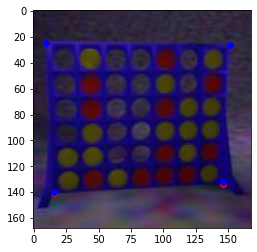

[[ 10.9237385  23.007723 ]
 [151.71558    26.04371  ]
 [153.29926   140.0684   ]
 [  9.534453  143.10626  ]]


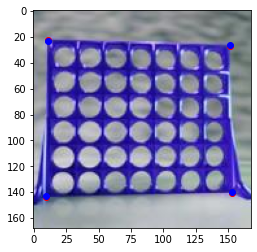

[[ 25.342367  30.713383]
 [150.61665   35.505264]
 [141.17383  137.66624 ]
 [ 33.27531  118.52673 ]]


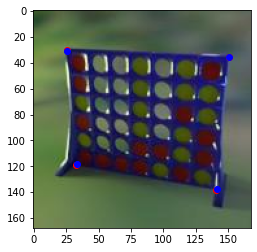

[[157.16563   22.154243]
 [ 13.421698  25.063688]
 [  9.151557 145.17776 ]
 [164.03337  146.64183 ]]


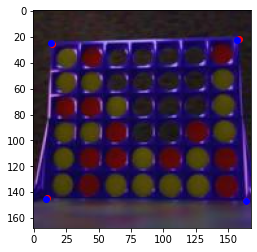

[[163.13445   21.872349]
 [  9.709922  21.728329]
 [ 16.876623 137.27908 ]
 [155.74341  141.51051 ]]


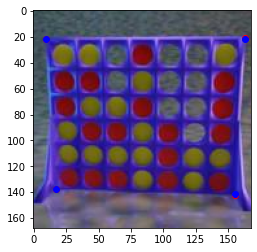

In [11]:
show()

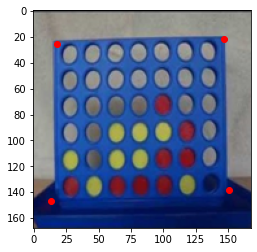

In [12]:
# test on real image
test_img = Image.open('hqdefault.jpg')
test_img = test_img.resize((168, 168))
test_img = test_img.convert('RGB')
imgT = to_tensor(test_img)
imgT = imgT.unsqueeze(0)
imgT = imgT.to(DEVICE)
outputs = model(imgT)
outputs = outputs.cpu().detach().numpy()
outputs = outputs.reshape(4, 2)
outputs = outputs * 168
plt.imshow(test_img)
plt.plot(outputs[:, 0], outputs[:, 1], 'ro')